In this Project, I will introduce you to a machine learning project on pneumonia detection with the Python programming language. Pneumonia is an inflammatory condition of the lung mainly affecting the small air sacs called alveoli.

## Introduction to Pneumonia Detection
Pneumonia is an infectious and fatal respiratory disease caused by bacteria, fungi, or a virus that infects human lung air sacs with a load full of fluid or pus.
Chest x-rays are the common method used to diagnose pneumonia and it takes a medical expert to assess the result of the x-ray. The troublesome method of detecting pneumonia leads to loss of life due to improper diagnosis and treatment.

With the emerging computing power, the development of an automatic pneumonia detection and disease treatment system is now possible, especially if the patient is in a remote area and medical services are limited.

### Importing Libraries

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


### Setting UP Locations

In [20]:
TRAIN_DIR = "/home/taseermehboob/Desktop/Machine Learning Projects/Pneumonia Detection CNN/chest_xray/train"
VAL_DIR   = "/home/taseermehboob/Desktop/Machine Learning Projects/Pneumonia Detection CNN/chest_xray/val"


### Using Augmentation on Data

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Computing Class Weights

In [26]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight = dict(enumerate(class_weights))
print(class_weight)

{0: 1.9448173005219984, 1: 0.6730322580645162}


# Transfer Learning
Transfer learning is highly effective for pneumonia detection because medical imaging datasets are usually small, imbalanced, and expensive to label, while deep CNNs require large amounts of data to learn robust features. Pretrained models such as DenseNet or ResNet are trained on millions of images and already learn low-level and mid-level visual features (edges, textures, shapes) that are also present in chest X-rays.

In pneumonia detection, the model does not need to relearn basic visual patterns; instead, it only needs to fine-tune higher-level representations to recognize subtle lung opacities, consolidations, and texture irregularities. This leads to faster convergence, better generalization, and higher recall, which is critical in medical diagnosis where missing a positive case is costly.

Additionally, transfer learning reduces overfitting, improves stability on limited data, and enables explainable attention patterns (via Grad-CAM) that align better with anatomical regions, making it the preferred and industry-standard approach for medical image analysis.

#### Here we will use DenseNet121

In [27]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

In [29]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Recall(name="recall"),
        Precision(name="precision"),
        AUC(name="auc")
    ]
)

In [30]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weight
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.8119 - auc: 0.9082 - loss: 0.3862 - precision: 0.9343 - recall: 0.8034 - val_accuracy: 0.8125 - val_auc: 0.8906 - val_loss: 0.3775 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.9162 - auc: 0.9709 - loss: 0.2216 - precision: 0.9723 - recall: 0.9133 - val_accuracy: 0.8125 - val_auc: 0.9375 - val_loss: 0.3381 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9224 - auc: 0.9760 - loss: 0.1964 - precision: 0.9769 - recall: 0.9172 - val_accuracy: 0.8750 - val_auc: 0.9375 - val_loss: 0.2997 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.9304 - auc: 0.9810 - loss: 0.1755 - precision: 0.9777 - recall: 0.9275 - val_accuracy: 0.8125 - val_auc: 0.9531 - val_loss: 0.2906 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 5/5
163/163 ━━━━━━━━━━━━━━

#### Unfreezing Last 40 Layers and training Again
Here the training will start from the previous accuracy but with new 40 layers which are close to output layer so the model will learn new parameters and will work down with it.

In [31]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Recall(name="recall"),
        Precision(name="precision"),
        AUC(name="auc")
    ]
)


In [33]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.9352 - auc: 0.9745 - loss: 0.2223 - precision: 0.9604 - recall: 0.9520 - val_accuracy: 0.9375 - val_auc: 0.9688 - val_loss: 0.2486 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9312 - auc: 0.9832 - loss: 0.1639 - precision: 0.9803 - recall: 0.9259 - val_accuracy: 0.9375 - val_auc: 0.9844 - val_loss: 0.2027 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.9394 - auc: 0.9837 - loss: 0.1582 - precision: 0.9824 - recall: 0.9352 - val_accuracy: 0.9375 - val_auc: 0.9844 - val_loss: 0.1753 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.9392 - auc: 0.9843 - loss: 0.1562 - precision: 0.9806 - recall: 0.9368 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1582 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 5/10
163/163 ━━━━━━━━━

In [34]:
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = (y_pred_prob > 0.3).astype(int)  # Recall-optimized threshold


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Clean Confusion Matrix

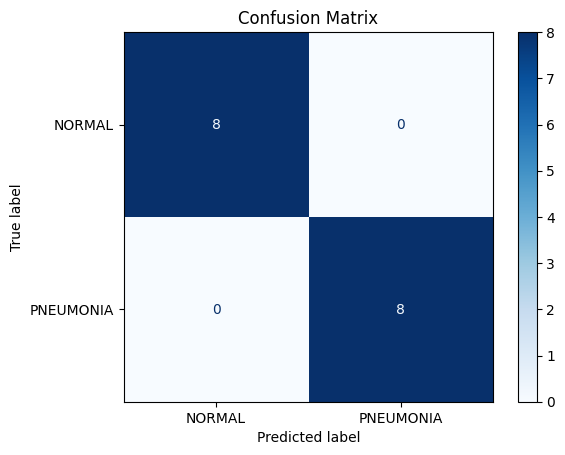

In [35]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NORMAL", "PNEUMONIA"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## ROC, AUC 

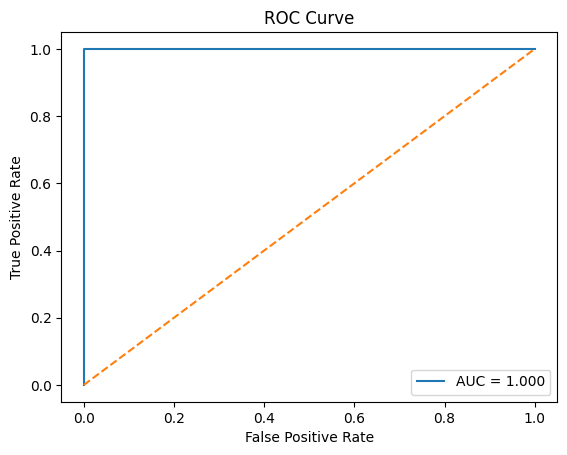

In [36]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Predicting New Image 

In [37]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError("Image not found or unreadable")

    img = cv2.resize(img, (224, 224))
    img = img / 255.0          # Same normalization as training
    img = np.expand_dims(img, axis=0)

    return img


In [38]:
def predict_pneumonia(image_path, model, threshold=0.3):

    img = preprocess_image(image_path)

    prob = float(model.predict(img)[0][0])

    prediction = "PNEUMONIA" if prob >= threshold else "NORMAL"

    return {
        "prediction": prediction,
        "pneumonia_probability": round(prob, 4),
        "normal_probability": round(1 - prob, 4),
        "threshold_used": threshold
    }


In [40]:
image_path = "/home/taseermehboob/Desktop/Machine Learning Projects/Pneumonia Detection CNN/chest_xray/test/PNEUMONIA/person8_virus_27.jpeg"

result = predict_pneumonia(image_path, model)

print("🩺 Diagnosis Result")
print("-------------------")
print(f"Prediction          : {result['prediction']}")
print(f"Pneumonia Probability: {result['pneumonia_probability']}")
print(f"Normal Probability  : {result['normal_probability']}")
print(f"Threshold Used      : {result['threshold_used']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🩺 Diagnosis Result
-------------------
Prediction          : PNEUMONIA
Pneumonia Probability: 0.9412
Normal Probability  : 0.0588
Threshold Used      : 0.3


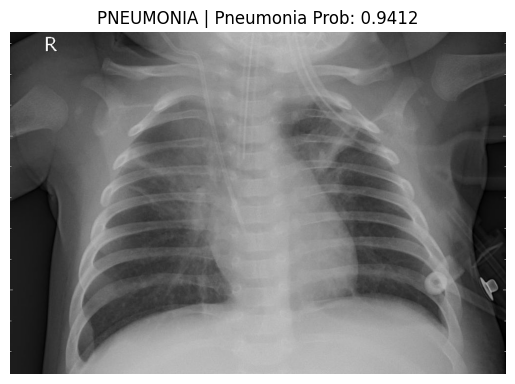

In [41]:
import matplotlib.pyplot as plt

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title(f"{result['prediction']} | Pneumonia Prob: {result['pneumonia_probability']}")
plt.show()


# Saving Model

In [50]:
model.save("pneumonia_detector_densenet121.h5")